Taller 1.

Herraminetas Computacionales

Camilo Santiago Castillo Lasso

201412050

Se importan las librerias que seran usadas

In [3]:
import os
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Funcion que retorna la serie IDEAM 

Parametros: nombre de la ciudad

retorno: serie_IDEAM

In [4]:
base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
def serie_IDEAM(ciudad):
    serie_csvIDEAM=os.path.join(base_dir,ciudad,'IDEAM'+'.csv')
    serie_IDEAM=pd.read_csv(serie_csvIDEAM, sep=';',encoding='latin-1')
    return serie_IDEAM

Funcion que retorna la serie NREL 

Parametros: nombre de la ciudad

retorno: serie_NREL

In [5]:
def serie_NREL(ciudad):
    serie_csvNREL=os.path.join(base_dir,ciudad,'NREL'+'.csv')
    serie_NREL=pd.read_csv(serie_csvNREL, sep=';',encoding='latin-1')
    return serie_NREL

Funcion que retorna las series IDEAM y NREL.

Parametros: nombre ciudad.

retorna: serie_IDEAM, serie_NREL

In [6]:
def darSeries(ciudad):
    return serie_IDEAM(ciudad), serie_NREL(ciudad)

Funcion que retorna la energia total en $kWh/m^2$ para cada mes de la serie horaria.

Parametros: serie horaria.

Retorna: serie con el total de energia y dias por mes

In [7]:
def ghi_mensual(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for agno in agnos:
        for mes in range(1,13):
            
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/1000
            
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                        "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
            
    return ghi_df

Funcion que calcula el promedio de energia diario mensual para la serie.

Parametros: Serie mensual.

Retorna: Serie con el promedio diaria mensual de energia en $kWh/m^2$.

In [8]:
def ghi_dia(serie_ghi_mensual):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes))
                                         ,"DIAS"].item()
            
            ghi_diario = serie_ghi_mensual.loc[(
                (serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes)),
                "GHImes"].item()/dias
            
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
            
    return ghi_df

Funcion que calcula el promedio de energia diario mensual a partir de una serie horaria.

Parametros: serie horaria

Retorna: serie con el promedio diario mensual.

In [9]:
def promDiaMen(serieHoraria):
        
    ghiMensual=ghi_mensual(serieHoraria)
    ghiDiario=ghi_dia(ghiMensual)
    datos=sorted(ghiDiario['GHIdiario'])
    return datos

Funcion que realiza una grafica de la distribucion de la energia mensula promedio a partir de una serie horaria.

Parametros: serie horaria, nombre de la serie, color de la serie

In [10]:
def graficarDistribucionDeEnergia(serieHoraria, nombre, color, datosIdeam):

    datos=promDiaMen(serieHoraria)
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    numdatos = range(len(datos))
    pylab.plot(numdatos,datos/datosIdeam[0],color, label=nombre)
    pylab.legend(loc='upper left')

Prueba de el funcionamineto de las funciones planteadas.

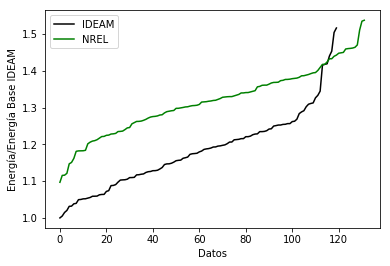

In [11]:
ideam, nrel=darSeries('Valledupar')
datosIdeam=promDiaMen(ideam)
graficarDistribucionDeEnergia(ideam, 'IDEAM','-k',datosIdeam)
graficarDistribucionDeEnergia(nrel, 'NREL','-g',datosIdeam)

Funcion que calcula la enerergia que se obtendra el 99% de las veces a partir de una serie horaria.

Parametros: serie horaria.

Retorna: valor de la ENFICC

In [12]:
def percentil1(serieHoraria):
    percentil=0.01
    
    ghiMensual=ghi_mensual(serieHoraria)
    ghiDiario=ghi_dia(ghiMensual)
    
    enficc=ghiDiario.quantile(q=percentil, numeric_only=True)['GHIdiario']
    return enficc

Funcion que extrae de un dataFrame el mes y año indicado

Parametros: serie, año, mes de inicio, mes de fin

Retorna: serie cortada

In [13]:
def cort(serie,año,mesesInicio,mesesFin):
    corta=serie[(serie['AÑO'] == año) &(serie['MES'] >= mesesInicio) &
                        (serie['MES'] <= mesesFin)]

    return corta

Funcion que calcula la media y la desviacion estandar poblacional a partir de una columna de datos.

Parametros: columna de la serie de datos.

Retorna: media y desviacion estandar poblacional.

In [14]:
def prom_desv(ColumnaSerie):
    return np.mean(ColumnaSerie), np.std(ColumnaSerie)

Funcion que ajusta una serie larga a partir de una serie corta de refencia.

Parametros: serie corta, serie larga

Retorna: serie larga con el ajuste de curva realizado

In [61]:
def mcp(seCorta, seLarga, seLargaCort):
    mu_y, desv_y=prom_desv(seCorta)
    mu_x, desv_x=prom_desv(seLargaCort)
    y=(mu_y-(desv_y/desv_x)*mu_x)+(desv_y/desv_x)*seLarga
    return y

Ejemplo del ajuste con la ciudad de Valledupar utilizando los tres primeros meses $3meses *30dias * 24horas=2160$

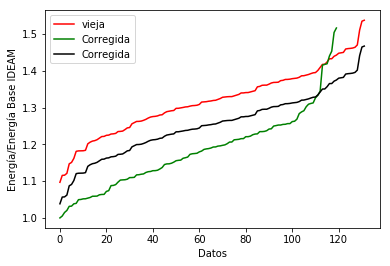

In [16]:
ideam,nrel=darSeries('Valledupar')
corta=ideam['IDEAM']
cCorregida=mcp(corta[:2160],nrel['NREL'])
datosIdeam=promDiaMen(ideam)
graficarDistribucionDeEnergia(nrel,'vieja','-r',datosIdeam)
graficarDistribucionDeEnergia(ideam,'Corregida','-g',datosIdeam)
nuevaSerie=nrel
nuevaSerie['NREL']=cCorregida
graficarDistribucionDeEnergia(nuevaSerie,'Corregida','-k',datosIdeam)

Funcion que a partir de un nombre de ciudad y un numero de meses grafica la distribucion de energia corregida, del ideam y del nrel.

Parametros: nombre ciudad, cantidad de meses para realizar el juste.

In [64]:
def graficarPrediccion(ciudad, año,mesesInicio, mesesFin):
    ideam, nrel=darSeries(ciudad)
    ideamCortada=cort(ideam,año,mesesInicio,mesesFin)['IDEAM'] 
    cCorregida=mcp(ideamCortada,nrel['NREL'],cort(nrel,año,mesesInicio,mesesFin)['NREL'])
    datosIdeam=promDiaMen(ideam)
    graficarDistribucionDeEnergia(nrel,'vieja','-r',datosIdeam)
    graficarDistribucionDeEnergia(ideam,'IDEAM','-g',datosIdeam)
    nuevaSerie=nrel
    nuevaSerie['NREL']=cCorregida
    graficarDistribucionDeEnergia(nuevaSerie,'Corregida','-k',datosIdeam)



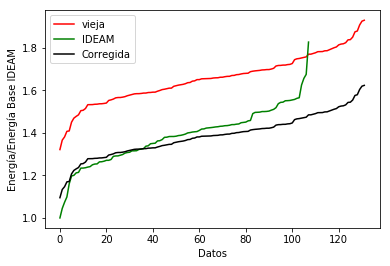

In [66]:
graficarPrediccion('Cali',2007,3,6)

Funcion que calcula el mean bias(MB)

Parametros: ciudad, año, mes de inicio, mes de fin

retorna: MB, serie nrel para calcular el mean bias relativo

In [133]:
def MB(ciudad, año, mesesInicio, mesesFin):
    ideam, nrel=darSeries(ciudad)
    ideamCortada=cort(ideam, año, mesesInicio, mesesFin)["IDEAM"]
    nrelCortada=cort(nrel, año, mesesInicio, mesesFin)["NREL"]
    N=len(nrelCortada)
    rest=array(nrelCortada)-array(ideamCortada)
    suma=sum(rest)
    return suma/N, nrel

Funcion que calcula el mean bias realtivo (rMB)

Parametros: ciudad, año, mes de inicio, mes de fin

retorna: rMB

In [142]:
def rMB(ciudad, año, mesesInicio, mesesFin):
    mb, nrel=MB(ciudad,año,mesesInicio,mesesFin)
    nrelCortado=cort(nrel,año,mesesInicio,mesesFin)['NREL']
    suma=sum(nrelCortado)
    N=len(nrelCortado)
    div=suma/N
    r=mb/div
    return r

Funcion que calcula el root mean square deviation (RMSD)

Parametros: ciudad, año, mes de inicio, mes de fin

retorna: RMSD, serie nrel


In [154]:
def RMSD(ciudad, año, mesesInicio, mesesFin):
    ideam, nrel=darSeries(ciudad)
    ideamCortada=cort(ideam, año, mesesInicio, mesesFin)["IDEAM"]
    nrelCortada=cort(nrel, año, mesesInicio, mesesFin)["NREL"]
    N=len(nrelCortada)
    rest=(array(nrelCortada)-array(ideamCortada))**2
    suma=sum(rest)
    div=suma/N
    sq=div**(.5)
    return sq, nrel

Funcion que calcula el root mean square deviation relativo(RMSD)

Parametros: ciudad, año, mes de inicio, mes de fin

retorna: rRMSD

In [155]:
def rRMSD(ciudad, año, mesesInicio, mesesFin):
    mb, nrel=RMSD(ciudad,año,mesesInicio,mesesFin)
    nrelCortado=cort(nrel,año,mesesInicio,mesesFin)['NREL']
    suma=sum(nrelCortado)
    N=len(nrelCortado)
    div=suma/N
    r=mb/div
    return r


In [156]:
rRMSD('Cali',2007,1,1)

0.50026936424055679